In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve
import pandas as pd

In [2]:
#Calculate thermodynamic properties of moist air
class MoistAirProperties:
    # Constants
    R_AIR = 287.0
    R_VAPOR = 461.5
    CP_AIR = 1006.0
    CP_VAPOR = 1860.0
    CP_LIQUID = 4186.0
    H_FG0 = 2.501e6
    T_REF = 273.15
    P_REF = 101325.0
    
    @staticmethod
    def saturation_pressure(T):
        T_celsius = T - 273.15
        return 611.2 * np.exp(17.67 * T_celsius / (T_celsius + 243.5))
    
    @staticmethod
    def saturation_humidity_ratio(T, P):
        P_sat = MoistAirProperties.saturation_pressure(T)
        return 0.622 * P_sat / (P - P_sat)
    
    @staticmethod
    def dew_point(omega, P):
        P_v = omega * P / (0.622 + omega)
        def equation(T):
            return MoistAirProperties.saturation_pressure(T) - P_v
        return fsolve(equation, 290.0)[0]
    
    @staticmethod
    def relative_humidity(T, P, omega):
        omega_sat = MoistAirProperties.saturation_humidity_ratio(T, P)
        P_sat = MoistAirProperties.saturation_pressure(T)
        P_v = omega * P / (0.622 + omega)
        phi = P_v / P_sat
        return np.clip(phi, 0, 1)
    
    @staticmethod
    def specific_enthalpy(T, omega):
        return (MoistAirProperties.CP_AIR * T + omega * (MoistAirProperties.H_FG0 + MoistAirProperties.CP_VAPOR * T))
    
    @staticmethod
    def latent_heat(T):
        T_celsius = T - 273.15
        return MoistAirProperties.H_FG0 - 2370 * T_celsius
    
    @staticmethod
    def specific_entropy(T, P, omega):
        s_air = (MoistAirProperties.CP_AIR * np.log(T / MoistAirProperties.T_REF) - MoistAirProperties.R_AIR * np.log(P / MoistAirProperties.P_REF))
        
        if omega > 0:
            P_v = omega * P / (0.622 + omega)
            s_vapor = (MoistAirProperties.CP_VAPOR * np.log(T / MoistAirProperties.T_REF) - MoistAirProperties.R_VAPOR * np.log(P_v / MoistAirProperties.P_REF) + 
                      MoistAirProperties.H_FG0 / MoistAirProperties.T_REF)
            return s_air + omega * s_vapor
        return s_air
    
    @staticmethod
    def mixture_cp(omega):
        return MoistAirProperties.CP_AIR + omega * MoistAirProperties.CP_VAPOR

# Calculate entropy production rates
class EntropyProduction:
    @staticmethod
    def phase_change_entropy(T, m_dot_condensate):
        h_fg = MoistAirProperties.latent_heat(T)
        return -m_dot_condensate * h_fg / T
    
    @staticmethod
    def heat_transfer_entropy(Q_dot, T_hot, T_cold):
        if Q_dot == 0 or T_hot == T_cold:
            return 0.0
        return Q_dot * abs(1/T_cold - 1/T_hot)
    
    @staticmethod
    def pressure_drop_entropy(m_dot_air, omega, P_in, P_out):
        if P_in <= P_out:
            return 0.0
        return m_dot_air * MoistAirProperties.R_AIR * (1 + omega) * np.log(P_in / P_out)
    
    @staticmethod
    def entropy_budget_for_air(T, P, omega, m_dot_air, dT_dt, dP_dt, domega_dt, T_coolant=None):
        # Phase change entropy
        if domega_dt < 0:
            m_dot_condensate = -m_dot_air * domega_dt
            S_dot_phase = EntropyProduction.phase_change_entropy(T, m_dot_condensate)
        else:
            S_dot_phase = 0.0
        
        # Heat transfer entropy
        if T_coolant is not None and dT_dt != 0:
            Cp_mix = MoistAirProperties.mixture_cp(omega)
            Q_dot = -m_dot_air * Cp_mix * dT_dt
            if domega_dt < 0:
                h_fg = MoistAirProperties.latent_heat(T)
                Q_dot += -m_dot_air * h_fg * domega_dt
            S_dot_heat = EntropyProduction.heat_transfer_entropy(abs(Q_dot), T, T_coolant)
        else:
            S_dot_heat = 0.0
        
        # Pressure drop entropy
        if dP_dt < 0:
            P_drop = abs(dP_dt * 1.0)
            S_dot_pressure = EntropyProduction.pressure_drop_entropy(m_dot_air, omega, P, P - P_drop)
        else:
            S_dot_pressure = 0.0
        
        S_dot_air = S_dot_heat + S_dot_pressure - S_dot_phase
        return S_dot_air, S_dot_phase, S_dot_heat, S_dot_pressure
    
    @staticmethod
    def total_entropy_production(T, P, omega, m_dot_air, dT_dt, dP_dt, domega_dt, T_coolant=None):
        return EntropyProduction.entropy_budget_for_air(T, P, omega, m_dot_air, dT_dt, dP_dt, domega_dt, T_coolant)

# Atmospheric Water Harvester
class VCC_AWH_System:
    def __init__(self, m_dot_air, T_coolant, U_A, P_atm=101325.0):
        self.m_dot_air = m_dot_air
        self.T_coolant = T_coolant
        self.U_A = U_A
        self.P_atm = P_atm
    
    def derivatives(self, t, state):
        T, omega = state
        omega_sat = MoistAirProperties.saturation_humidity_ratio(T, self.P_atm)
        is_saturated = omega >= omega_sat * 0.999
        
        if is_saturated:
            omega = omega_sat
            dT = 0.1
            omega_sat_plus = MoistAirProperties.saturation_humidity_ratio(T + dT, self.P_atm)
            domega_sat_dT = (omega_sat_plus - omega_sat) / dT
            Cp_mix = MoistAirProperties.mixture_cp(omega)
            h_fg = MoistAirProperties.latent_heat(T)
            Q_dot_cooling = self.U_A * (T - self.T_coolant)
            dT_dt = -Q_dot_cooling / (self.m_dot_air * (Cp_mix + h_fg * abs(domega_sat_dT)))
            domega_dt = domega_sat_dT * dT_dt
        else:
            Cp_mix = MoistAirProperties.mixture_cp(omega)
            Q_dot_cooling = self.U_A * (T - self.T_coolant)
            dT_dt = -Q_dot_cooling / (self.m_dot_air * Cp_mix)
            domega_dt = 0.0
        
        return [dT_dt, domega_dt]
    
    def simulate(self, T_initial, omega_initial, t_span, t_eval=None):
        state_initial = [T_initial, omega_initial]
        return solve_ivp(self.derivatives, t_span, state_initial, method='LSODA', t_eval=t_eval, dense_output=True, max_step=1.0)
    
    def calculate_entropy_production(self, solution):
        t = solution.t
        T = solution.y[0]
        omega = solution.y[1]
        dT_dt = np.gradient(T, t)
        domega_dt = np.gradient(omega, t)
        dP_dt = np.zeros_like(t)
        S_dot_air = np.zeros_like(t)
        S_dot_phase = np.zeros_like(t)
        S_dot_heat = np.zeros_like(t)
        S_dot_pressure = np.zeros_like(t)
        
        for i in range(len(t)):
            S_dot_air[i], S_dot_phase[i], S_dot_heat[i], S_dot_pressure[i] = \
                EntropyProduction.total_entropy_production(T[i], self.P_atm, omega[i], self.m_dot_air, dT_dt[i], dP_dt[i], domega_dt[i], self.T_coolant)
        return S_dot_air, S_dot_phase, S_dot_heat, S_dot_pressure

# Simplified hurricane model using parcel theory and MEP principles
class HurricaneModel:    
    def __init__(self, T_surface, T_outflow, m_dot_air, evap_rate=0.0):
        self.T_surface = T_surface
        self.T_outflow = T_outflow
        self.m_dot_air = m_dot_air
        self.evap_rate = evap_rate
        self.g = 9.81
    
    def mep_forcing(self, state):
        T, P, omega = state
        S_dot_current = self.calculate_entropy_production_rate(state)
        delta = 1e-3
        grad_S = np.zeros(3)
        state_plus_T = [T + delta * T, P, omega]
        S_dot_plus_T = self.calculate_entropy_production_rate(state_plus_T)
        grad_S[0] = (S_dot_plus_T - S_dot_current) / (delta * T)
        state_plus_P = [T, P + delta * P, omega]
        S_dot_plus_P = self.calculate_entropy_production_rate(state_plus_P)
        grad_S[1] = (S_dot_plus_P - S_dot_current) / (delta * P)
        state_plus_omega = [T, P, omega + delta * max(omega, 0.001)]
        S_dot_plus_omega = self.calculate_entropy_production_rate(state_plus_omega)
        grad_S[2] = (S_dot_plus_omega - S_dot_current) / (delta * max(omega, 0.001))
        
        return grad_S
    
    def calculate_entropy_production_rate(self, state):
        T, P, omega = state
        eta_carnot = 1 - self.T_outflow / self.T_surface
        
        h_sat_surface = MoistAirProperties.specific_enthalpy(
            self.T_surface, 
            MoistAirProperties.saturation_humidity_ratio(self.T_surface, P))
        h_current = MoistAirProperties.specific_enthalpy(T, omega)
        delta_h = h_sat_surface - h_current
        
        power = self.m_dot_air * delta_h * eta_carnot
        S_dot = power / self.T_outflow + self.m_dot_air * delta_h * (1 - eta_carnot) / T
        return max(S_dot, 0)
    
    def derivatives(self, t, state):
        T, P, omega = state
        grad_S = self.mep_forcing(state)
        lambda_T = 0.01
        lambda_P = 10.0
        lambda_omega = 0.0001
        gamma_d = 9.8e-3
        w_vertical = 5.0
        dT_dt_adiabatic = -gamma_d * w_vertical
        rho = P / (MoistAirProperties.R_AIR * T * (1 + omega))
        dP_dt_hydrostatic = -rho * self.g * w_vertical
        altitude_factor = np.exp(-P / 50000)
        domega_dt_evap = self.evap_rate / self.m_dot_air * altitude_factor
        omega_sat = MoistAirProperties.saturation_humidity_ratio(T, P)
        domega_dt_cond = -0.1 * (omega - omega_sat) if omega > omega_sat else 0.0
        dT_dt = dT_dt_adiabatic + lambda_T * grad_S[0]
        dP_dt = dP_dt_hydrostatic + lambda_P * grad_S[1]
        domega_dt = domega_dt_evap + domega_dt_cond + lambda_omega * grad_S[2]
        
        if omega < 1e-6 and domega_dt < 0:
            domega_dt = 0
        
        return [dT_dt, dP_dt, domega_dt]
    
    def simulate(self, T_initial, P_initial, omega_initial, t_span, t_eval=None):
        state_initial = [T_initial, P_initial, omega_initial]
        return solve_ivp(self.derivatives, t_span, state_initial, method='LSODA', t_eval=t_eval, dense_output=True, max_step=10.0)
    
    def calculate_entropy_production(self, solution):
        t = solution.t
        T = solution.y[0]
        P = solution.y[1]
        omega = solution.y[2]
        
        S_dot_total = np.zeros_like(t)
        for i in range(len(t)):
            state = [T[i], P[i], omega[i]]
            S_dot_total[i] = self.calculate_entropy_production_rate(state)
        
        return S_dot_total

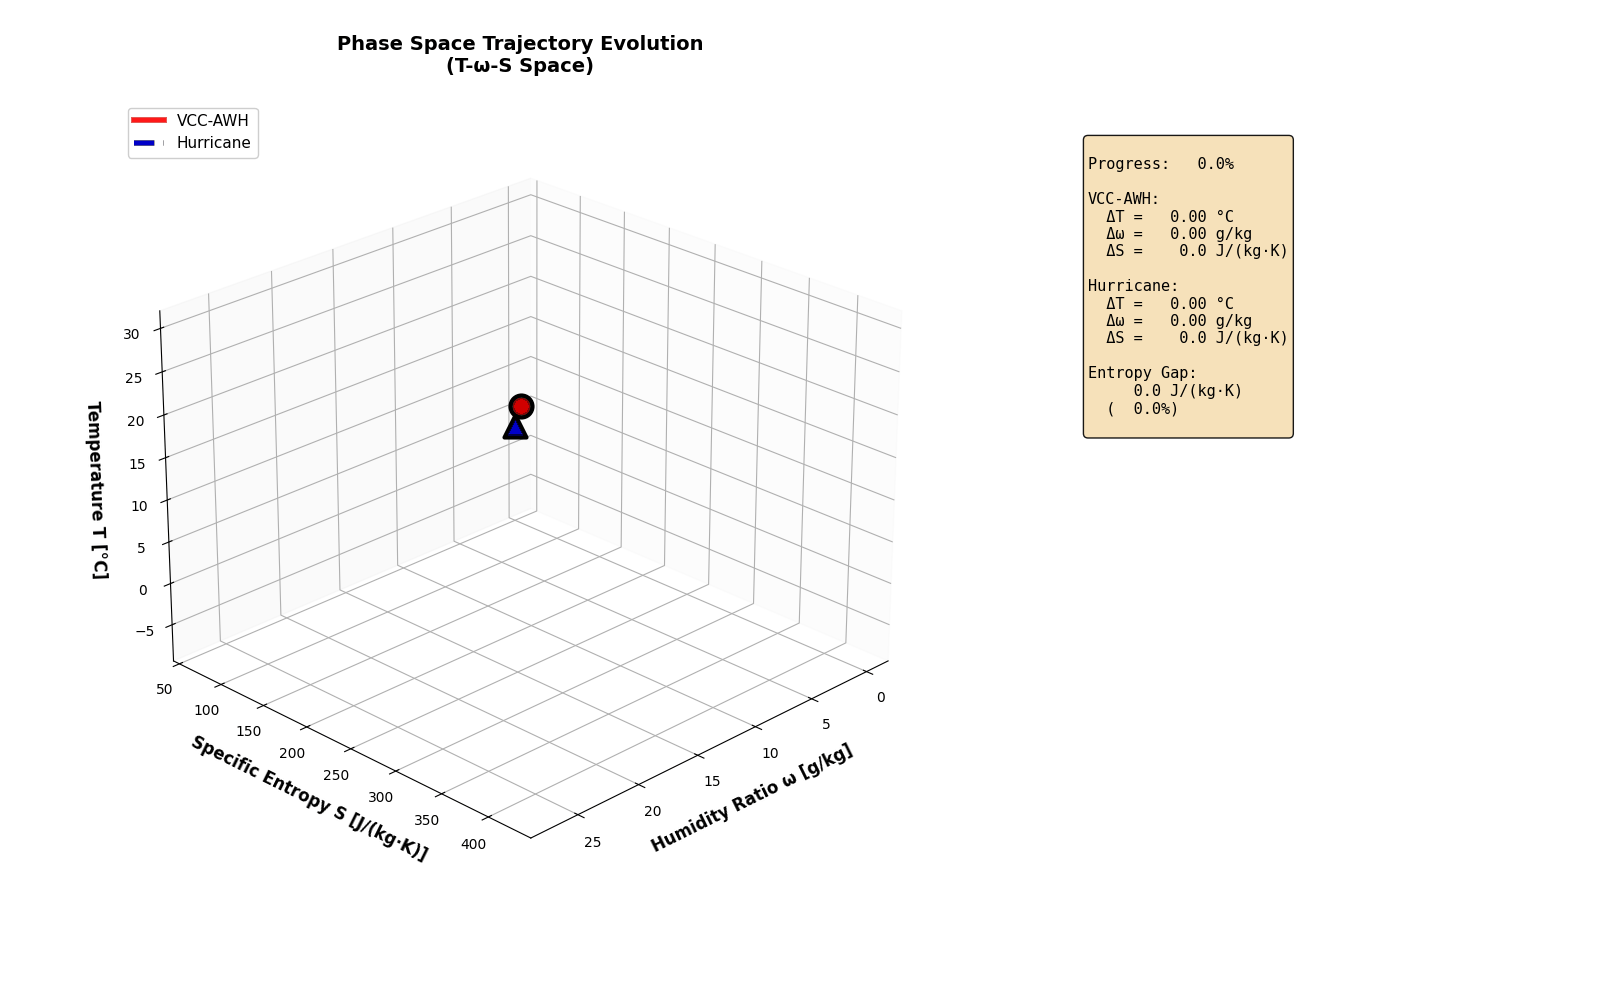

In [ ]:
# Run both VCC and Hurricane simulations  
def run_simulations():  
    # Ambient conditions
    T_ambient = 30 + 273.15  # 30 Kelvin
    P_ambient = 101325.0  # 1 atm
    RH_ambient = 0.80  # relative humidity
    
    omega_sat_ambient = MoistAirProperties.saturation_humidity_ratio(T_ambient, P_ambient)
    omega_ambient = RH_ambient * omega_sat_ambient
    
    # VCC-AWH System
    m_dot_air_vcc = 0.1  # kg/s
    T_coolant = 10 + 273.15  # 10 Kelvin
    U_A = 200.0  # W/K
    
    vcc_system = VCC_AWH_System(m_dot_air_vcc, T_coolant, U_A, P_ambient)
    
    t_span_vcc = (0, 700)
    t_eval_vcc = np.linspace(0, 700, 700)
    vcc_solution = vcc_system.simulate(T_ambient, omega_ambient, t_span_vcc, t_eval_vcc)
    
    # Hurricane Model
    T_surface = 28 + 273.15  # Kelvin
    T_outflow = -60 + 273.15  # Kelvin
    m_dot_air_hurr = 0.1  # kg/s
    evap_rate = 0.0001  # kg/s
    
    hurricane_model = HurricaneModel(T_surface, T_outflow, m_dot_air_hurr, evap_rate)
    
    t_span_hurr = (0, 700)
    t_eval_hurr = np.linspace(0, 700, 700)
    
    T_initial_hurr = T_ambient
    P_initial_hurr = P_ambient
    omega_initial_hurr = omega_ambient * 1.1
    
    hurricane_solution = hurricane_model.simulate(
        T_initial_hurr, P_initial_hurr, omega_initial_hurr,
        t_span_hurr, t_eval_hurr
    )
    return vcc_solution, hurricane_solution, vcc_system, hurricane_model

from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
import sys
from IPython.display import Image, display

""" Animation Pipeline for Phase Space Visualization
==========================================================
This script combines simulation and animation creation.
"""
# Script was generated with the help of Research Project Assistant (Copilot)
def create_evolution_animation(vcc_solution, hurricane_solution, vcc_system, hurricane_model, save_path='phase_space_evolution_v2.gif',
                               fps=24, duration=12):
    """
    Create animation showing pathways evolving over time with live metrics
    """
    # Extract and prepare data
    t_vcc = vcc_solution.t
    T_vcc = vcc_solution.y[0] - 273.15
    omega_vcc = vcc_solution.y[1] * 1000
    
    t_hurr = hurricane_solution.t
    T_hurr = hurricane_solution.y[0] - 273.15
    P_hurr = hurricane_solution.y[1]
    omega_hurr = hurricane_solution.y[2] * 1000
    
    # Calculate entropy
    S_vcc = np.array([MoistAirProperties.specific_entropy(T + 273.15, vcc_system.P_atm, omega/1000) for T, omega in zip(T_vcc, omega_vcc)])
    
    S_hurr = np.array([MoistAirProperties.specific_entropy(T + 273.15, P, omega/1000) for T, P, omega in zip(T_hurr, P_hurr, omega_hurr)])
    
    # Frame indices for synchronized animation
    total_frames = fps * duration
    frame_indices_vcc = np.linspace(0, len(t_vcc)-1, total_frames).astype(int)
    frame_indices_hurr = np.linspace(0, len(t_hurr)-1, total_frames).astype(int)
    
    # Create figure with 3D plot and metrics panel
    fig = plt.figure(figsize=(16, 10))
    
    # Main 3D plot (centered, larger)
    ax_3d = fig.add_subplot(1, 2, 1, projection='3d')
    
    # Metrics panel
    ax_metrics = fig.add_subplot(1, 2, 2)
    ax_metrics.axis('off')
    
    # Adjust subplot positions to center the 3D plot
    ax_3d.set_position([0.05, 0.1, 0.55, 0.8])  # [left, bottom, width, height]
    ax_metrics.set_position([0.65, 0.1, 0.3, 0.8])
    
    # Setup 3D plot
    omega_range = [min(omega_vcc.min(), omega_hurr.min()) - 2,
                   max(omega_vcc.max(), omega_hurr.max()) + 2]
    S_range = [min(S_vcc.min(), S_hurr.min()) - 50,
               max(S_vcc.max(), S_hurr.max()) + 50]
    T_range = [min(T_vcc.min(), T_hurr.min()) - 2,
               max(T_vcc.max(), T_hurr.max()) + 2]
    
    # Initialize plot elements
    line_vcc_3d, = ax_3d.plot([], [], [], 'r-', linewidth=4, 
                              label='VCC-AWH', alpha=0.9)
    line_hurr_3d, = ax_3d.plot([], [], [], 'b--', linewidth=4,
                               label='Hurricane', alpha=0.9)
    
    marker_vcc_3d = ax_3d.scatter([], [], [], c='red', s=250, marker='o',
                                  edgecolors='black', linewidths=3, zorder=10)
    marker_hurr_3d = ax_3d.scatter([], [], [], c='blue', s=250, marker='^',
                                   edgecolors='black', linewidths=3, zorder=10)
    
    # Start markers
    ax_3d.scatter([omega_vcc[0]], [S_vcc[0]], [T_vcc[0]],
                 c='darkred', s=150, marker='o', alpha=0.4,
                 edgecolors='black', linewidths=2)
    ax_3d.scatter([omega_hurr[0]], [S_hurr[0]], [T_hurr[0]],
                 c='darkblue', s=150, marker='^', alpha=0.4,
                 edgecolors='black', linewidths=2)
    
    ax_3d.set_xlabel('\nHumidity Ratio ω [g/kg]', fontsize=12, fontweight='bold')
    ax_3d.set_ylabel('\nSpecific Entropy S [J/(kg·K)]', fontsize=12, fontweight='bold')
    ax_3d.set_zlabel('\nTemperature T [°C]', fontsize=12, fontweight='bold')
    ax_3d.set_title('Phase Space Trajectory Evolution\n(T-ω-S Space)', 
                   fontsize=14, fontweight='bold', pad=20)
    ax_3d.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax_3d.set_xlim(omega_range)
    ax_3d.set_ylim(S_range)
    ax_3d.set_zlim(T_range)
    ax_3d.view_init(elev=25, azim=45)
    ax_3d.grid(True, alpha=0.3)
    
    # Make z-axis visible by adjusting pane transparency
    ax_3d.xaxis.pane.set_alpha(0.2)
    ax_3d.yaxis.pane.set_alpha(0.2)
    ax_3d.zaxis.pane.set_alpha(0.2)
    
    # Ensure z-axis is drawn
    ax_3d.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    # Metrics text box
    metrics_text = ax_metrics.text(0.1, 0.95, '', fontsize=11,
                                   verticalalignment='top', family='monospace',
                                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    def init():
        """Initialize animation"""
        line_vcc_3d.set_data([], [])
        line_vcc_3d.set_3d_properties([])
        line_hurr_3d.set_data([], [])
        line_hurr_3d.set_3d_properties([])
        return (line_vcc_3d, line_hurr_3d)
    
    def animate(frame):
        """Update animation"""
        idx_vcc = frame_indices_vcc[frame]
        idx_hurr = frame_indices_hurr[frame]
        
        # Update 3D paths
        line_vcc_3d.set_data(omega_vcc[:idx_vcc+1], S_vcc[:idx_vcc+1])
        line_vcc_3d.set_3d_properties(T_vcc[:idx_vcc+1])
        
        line_hurr_3d.set_data(omega_hurr[:idx_hurr+1], S_hurr[:idx_hurr+1])
        line_hurr_3d.set_3d_properties(T_hurr[:idx_hurr+1])
        
        # Update markers
        marker_vcc_3d._offsets3d = ([omega_vcc[idx_vcc]], 
                                    [S_vcc[idx_vcc]], 
                                    [T_vcc[idx_vcc]])
        marker_hurr_3d._offsets3d = ([omega_hurr[idx_hurr]], 
                                     [S_hurr[idx_hurr]], 
                                     [T_hurr[idx_hurr]])
        
        # Update metrics
        progress = (frame / total_frames) * 100
        
        dS_vcc = S_vcc[idx_vcc] - S_vcc[0]
        dS_hurr = S_hurr[idx_hurr] - S_hurr[0]
        dT_vcc = T_vcc[idx_vcc] - T_vcc[0]
        dT_hurr = T_hurr[idx_hurr] - T_hurr[0]
        dw_vcc = omega_vcc[idx_vcc] - omega_vcc[0]
        dw_hurr = omega_hurr[idx_hurr] - omega_hurr[0]
        
        metrics_str = f"""
Progress: {progress:5.1f}%

VCC-AWH:
  ΔT = {dT_vcc:6.2f} °C
  Δω = {dw_vcc:6.2f} g/kg
  ΔS = {dS_vcc:6.1f} J/(kg·K)

Hurricane:
  ΔT = {dT_hurr:6.2f} °C
  Δω = {dw_hurr:6.2f} g/kg
  ΔS = {dS_hurr:6.1f} J/(kg·K)

Entropy Gap:
  {abs(dS_hurr - dS_vcc):6.1f} J/(kg·K)
  ({abs(dS_hurr - dS_vcc)/(abs(dS_vcc)+1e-6)*100:5.1f}%)
        """
        
        metrics_text.set_text(metrics_str)
        
        return (line_vcc_3d, line_hurr_3d, marker_vcc_3d, marker_hurr_3d, metrics_text)
    
    # Create and save animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=total_frames, interval=1000/fps, blit=False, repeat=True)

    writer = PillowWriter(fps=fps)
    anim.save(save_path, writer=writer, dpi=100)
    plt.close(fig)
    return anim

def main():
    # Step 1: Run simulations
    vcc_sol, hurr_sol, vcc_sys, hurr_mod = run_simulations()
    
    # Step 2: Create animations
    anim1 = create_evolution_animation(
        vcc_sol, hurr_sol, vcc_sys, hurr_mod,
        save_path='phase_space_evolution_v2.gif',
        fps=24, duration=12
    )
    
    # Display animation
    display(Image(filename='phase_space_evolution_v2.gif'))

if __name__ == "__main__":
    main()


In [ ]:
# Descriptive statistics 
#Quantify the MEP gap 
def analyze_mep_gap(vcc_solution, hurricane_solution, vcc_system, hurricane_model):
    S_dot_vcc, _, _, _ = vcc_system.calculate_entropy_production(vcc_solution)
    S_dot_hurr = hurricane_model.calculate_entropy_production(hurricane_solution)
    
    results = {'VCC': {'mean_S_dot': np.mean(S_dot_vcc), 'max_S_dot': np.max(S_dot_vcc),'total_entropy': np.trapz(S_dot_vcc, vcc_solution.t)},
        'Hurricane': {'mean_S_dot': np.mean(S_dot_hurr), 'max_S_dot': np.max(S_dot_hurr),'total_entropy': np.trapz(S_dot_hurr, hurricane_solution.t)}}
    
    # Calculate water yield
    omega_vcc = vcc_solution.y[1]
    water_vcc = (omega_vcc[0] - omega_vcc[-1]) * vcc_system.m_dot_air * vcc_solution.t[-1]
    results['VCC']['final_water'] = water_vcc
    omega_hurr = hurricane_solution.y[2]
    water_hurr = (omega_hurr[0] - omega_hurr[-1]) * hurricane_model.m_dot_air * hurricane_solution.t[-1]
    results['Hurricane']['final_water'] = water_hurr
    
    if water_vcc > 0:
        results['VCC']['entropy_per_water'] = results['VCC']['total_entropy'] / water_vcc
    if water_hurr > 0:
        results['Hurricane']['entropy_per_water'] = results['Hurricane']['total_entropy'] / water_hurr
    
    mep_gap_mean = results['Hurricane']['mean_S_dot'] - results['VCC']['mean_S_dot']
    mep_gap_percent = (mep_gap_mean / results['Hurricane']['mean_S_dot']) * 100 if \
                      results['Hurricane']['mean_S_dot'] > 0 else 0
    
    results['MEP_gap'] = {'absolute': mep_gap_mean, 'percent': mep_gap_percent}
    return results
vcc_sol, hurr_sol, vcc_sys, hurr_mod = run_simulations()

# Analyze MEP gap
results = analyze_mep_gap(vcc_sol, hurr_sol, vcc_sys, hurr_mod)

# Create descriptive statistics dataframe
stats_data = {'Metric': ['Mean Entropy Production Rate (W/K)', 'Max Entropy Production Rate (W/K)', 'Total Entropy Production (J/K)', 'Water Yield (kg)', 'Entropy per Water (J/(kg·K))'],
    'VCC-AWH': [results['VCC']['mean_S_dot'], results['VCC']['max_S_dot'], results['VCC']['total_entropy'], results['VCC'].get('final_water', 0), results['VCC'].get('entropy_per_water', 0)],
    'Hurricane': [results['Hurricane']['mean_S_dot'], results['Hurricane']['max_S_dot'], results['Hurricane']['total_entropy'], results['Hurricane'].get('final_water', 0), results['Hurricane'].get('entropy_per_water', 0)]}
stats_df = pd.DataFrame(stats_data)

print("Descriptive Statistics: ")
print("=" * 80)
print(stats_df.to_string(index=False))
print(f"MEP Gap (Absolute): {results['MEP_gap']['absolute']:.4f} W/K")
print(f"MEP Gap (Percent): {results['MEP_gap']['percent']:.2f}%")

Descriptive Statistics: 
                            Metric   VCC-AWH    Hurricane
Mean Entropy Production Rate (W/K)  0.021774    39.725489
 Max Entropy Production Rate (W/K)  6.050757    60.633847
    Total Entropy Production (J/K) 12.233645 27817.264313
                  Water Yield (kg)  0.968428     1.675594
      Entropy per Water (J/(kg·K)) 12.632472 16601.437787
MEP Gap (Absolute): 39.7037 W/K
MEP Gap (Percent): 99.95%


### Citation
1. Microsoft (2025). Response to prompt: "How can I visualize an animated time series in a three dimensional plane for temperature-humidity ratio (\omega)- entropy?." [Large language model]. Microsoft Copilot 